In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import scipy.sparse as sp
import time
import itertools
import scipy
import cvxpy as cp
import random

def create_array(orig_array, percentage):
    # Compute the number of unique rows we'll use
    num_rows = int(orig_array.shape[0] *percentage)
    
    # If num_rows is zero, we should at least select one row.
    num_rows = max(1, num_rows)
    
    # Randomly select 'num_rows' row indices without replacement
    unique_indices = np.random.choice(orig_array.shape[0], size=num_rows, replace=False)

    # Select the unique rows from the original array
    unique_rows = orig_array[unique_indices, :]
    
    # Now, we'll need to repeat these rows to fill the new array
    num_repeats = int(np.ceil(orig_array.shape[0] / float(num_rows)))

    # Repeat the unique rows to create a new array
    new_array = np.repeat(unique_rows, num_repeats, axis=0)
    
    # Make sure the new array has the same number of rows as the original array
    new_array = new_array[:orig_array.shape[0], :]
    
    return new_array

class Genetic_Algorithm:
    def __init__(self, img1, img2, beta, turnover_rate, parent_to_children, random_selection, add_neighbours):
        
        #hyperparameters
        self.beta = beta
        self.turnover_rate = turnover_rate
        self.parent_to_children = parent_to_children
        self.random_selection = random_selection
        self.add_neighbours = add_neighbours
        
        
        self.N = img1.shape[0]
        self.M = img2.shape[0]
        self.img1 = img1.flatten()
        self.img2 = img2.flatten()
        self.b_eq = np.concatenate((self.img1, self.img2))
        self.non_zero_indices = []
        
        start = time.time()
        #print("initializing omega...")
        self.current_gamma, self.active_indices = self.initialize_omega()
        #print("omega initialized in %5.3f. s" %(time.time()-start))
        
        start = time.time()
        #print("initializing cost vector...")
        self.current_cost_vector = self.get_cost(self.active_indices)
        #print("cost vector initialized in %5.3f. s" %(time.time()-start))
        start = time.time()
        #print("initializing full model...")
        self.current_gamma, self.constraints_RMP, self.current_kantorovich_u, self.current_kantorovich_v = self.initialize_model()
        #print("full model initialized in %5.3f. s" %(time.time()-start))

        #stats
        self.cost = []
        self.time_child = []
        self.children_sampled = []
        self.time_model = []
        self.len_children = []
        
    def initialize_model(self):
        indices_row = np.array([])
        indices_col = np.array([])

        for indices in range(self.N**2):
            gamma_indices = np.where(self.active_indices.transpose()[0] == indices)[0]
            indices_row = np.concatenate((indices_row, gamma_indices))
            indices_col = np.concatenate((indices_col, np.ones(len(gamma_indices))*indices))

        for indices in range(self.M**2):
            gamma_indices = np.where(self.active_indices.transpose()[1] == indices)[0]
            indices_row = np.concatenate((indices_row, gamma_indices))
            indices_col = np.concatenate((indices_col, np.ones(len(gamma_indices))*(indices+self.N**2)))

        A_eq = sp.csr_matrix((np.ones(len(indices_col)), (indices_col, indices_row)), shape=( self.N**2 + self.M**2, len(self.active_indices)))
        gamma = cp.Variable(len(self.current_cost_vector))
        objective = cp.Minimize(self.current_cost_vector @ gamma)
        constraints = [A_eq @ gamma == self.b_eq, gamma >= 0]
        prob = cp.Problem(objective, constraints)
        gamma.value = self.current_gamma
        prob.solve(warm_start = True, solver=cp.GUROBI)
        primal_solution = gamma.value
        dual_solution = -constraints[0].dual_value
        return primal_solution, A_eq, dual_solution[:self.N**2], dual_solution[self.N**2:]

    def barycentric_distance(self, x, y):
        # mean squared deviation from the classical barycenter of the xi
        #rescale x and y to be in [0,1]
        x = x / self.N
        y = y / self.N
        barycenter = x * 0.5 + y * 0.5
        barycenter = 0.5 * np.sum((x - barycenter) ** 2, axis=0) + 0.5 * np.sum(
            (y - barycenter) ** 2, axis=0)
        return barycenter

    def get_cost(self, vector):
        #for each pair of active pixels, compute the cost of moving the first pixel to the second

        indices_img1 = np.array(np.unravel_index(vector.transpose()[0], (self.N, self.N)))
        indices_img2 = np.array(np.unravel_index(vector.transpose()[1], (self.M, self.M)))
        cost_vector = self.barycentric_distance(indices_img1, indices_img2)

        return cost_vector

    def compute_gain(self, cost, children):
        return self.current_kantorovich_u[children.transpose()[0]] + self.current_kantorovich_v[children.transpose()[1]] - cost

    def find_best_child(self):
        parent = self.non_zero_indices.copy().transpose()
        #print(parent.shape)
        #select parent_to_children% of parents
        #chosen_parents = np.random.choice(parent.shape[1], size=int(parent.shape[1]*self.parent_to_children), replace=False)
       
        #take the ceil of 1/parent_to_children and repeat the chosen_parents that many times and then take the first self.n**2
        #parent = np.repeat(parent[chosen_parents], int(np.ceil(1/parent_to_children)), axis=1)[:self.N**2]
        parent = create_array(parent, self.parent_to_children)
        #select one of the two images at random
        index = random.randint(0,1)
        parent[index] = np.random.randint(0, self.N**2, size=len(parent[1]))
        
        
        children = parent.copy().transpose()
        
        gain = self.compute_gain(self.get_cost(children), children) 
        print(gain)
        best_children = children[np.where(gain > 0)[0]]
        
        #now take the best turnover_rate% or just some random turnover_rate
        if self.random_selection:                  
            best_children = children[np.argsort(gain)[-int(best_children.shape[0]*turnover_rate):]]
        else:
            chosen_children = np.random.choice(best_children.shape[0], size=int(best_children.shape[0]*turnover_rate), replace=False)
            best_children = best_children[chosen_children]
            
        
        
        if self.add_neighbours:
            parent[index] = np.clip(parent[(index+1)%2]+1, 0, self.N**1)
            children = parent.copy().transpose()
            gain = self.compute_gain(self.get_cost(children), children)

            best_children = np.vstack((best_children,children[np.where(gain > 0)[0]]))
            parent[index] = np.clip(parent[(index+1)%2]-1, 0, self.N**2-1)
            children = parent.copy().transpose()
            gain = self.compute_gain(self.get_cost(children), children)
            best_children = np.vstack((best_children,children[np.where(gain > 0)[0]]))

            parent[index] = np.clip(parent[(index+1)%2]+self.N, 0, self.N**2-1)
            children = parent.copy().transpose()
            gain = self.compute_gain(self.get_cost(children), children)
            best_children = np.vstack((best_children,children[np.where(gain > 0)[0]]))

            parent[index] = np.clip(parent[(index+1)%2]-self.N, 0, self.N**2-1)
            children = parent.copy().transpose()
            gain = self.compute_gain(self.get_cost(children), children)
            best_children = np.vstack((best_children,children[np.where(gain > 0)[0]]))
        
        
        ### here we can decide to take the best n children instead of all ###
        
        
        #if len(best_children) > 4096:
        #    best_children = children[np.argsort(gain)[-2:]]
        
        

        return best_children

    
    def get_single_cost(self, child):
        i = np.array(np.unravel_index(child[0], (self.N, self.N)))
        j = np.array(np.unravel_index(child[1], (self.M, self.M)))
        return self.barycentric_distance(i,j)

    def initialize_omega(self):
        #the north west rule is used to initialise omega
        #we start with the first pixel of each image
        omega = [[0,0]]
        i, j = 0, 0
        b = np.array([self.img1[0], self.img2[0]])

        current_gamma = [min(b[0], b[1])]
        while i < self.N**2-1 and j < self.M**2-1:
            gamma = min(b[0], b[1])
            b = b - gamma
            if np.argmin(b) == 0:
                i += 1
                b[0] += self.img1[i]
                omega.append([i, j])
                current_gamma.append(gamma)
            else:
                j += 1
                b[1] += self.img2[j]
                omega.append([i, j])
                current_gamma.append(gamma)
        while i < self.N**2-1:
            i += 1
            omega.append([i, j])
            current_gamma.append(0)
        while j < self.M**2-1:
            j += 1
            omega.append([i, j])
            current_gamma.append(0)

        return np.array(current_gamma), np.array(omega)
    
    def run(self, max_iter, max_sample, max_runtime):
        start_runtime = time.time()
        for _ in tqdm(range(max_iter)):
            if time.time() - start_runtime > max_runtime:
                break
            start = time.time()
            self.non_zero_indices = self.active_indices[np.nonzero(self.current_gamma)]
            sample = 0
            #divide the non zero indices into chunks of size chunk_size
            best_children = self.find_best_child()
            while best_children.shape[0] == 0 and sample < max_sample:
                sample += len(self.non_zero_indices)
                best_children = self.find_best_child()

            self.children_sampled.append(sample)
            self.time_child.append(time.time() - start)

            self.current_cost_vector = np.append(self.current_cost_vector, self.get_cost(best_children))
            self.current_gamma = np.append(self.current_gamma, np.zeros(best_children.shape[0]))
            for child in best_children:
                 self.active_indices = np.vstack((self.active_indices, child))
                 child_mu, child_nu = self.active_indices[-1]
                 A_col = np.zeros(self.N**2 + self.M**2)
                 A_col[child_mu] = 1
                 A_col[self.N**2 + child_nu] = 1
                 self.constraints_RMP = sp.hstack((self.constraints_RMP, A_col.reshape(-1,1)))

            if self.active_indices.shape[0] > int(self.beta*(self.N**2 + self.M**2)):
                #delete first (beta-1)*(N^2 + M^2) 0 entries
                zero_indices = np.where(self.current_gamma == 0)[:int((beta-1)*(self.N**2 + self.M**2))]
                self.active_indices = np.delete(self.active_indices, zero_indices, axis=0)
                self.current_cost_vector = np.delete(self.current_cost_vector, zero_indices)
                self.current_gamma = np.delete(self.current_gamma, zero_indices)
                self.current_gamma, self.constraints_RMP, self.current_kantorovich_u, self.current_kantorovich_v = self.initialize_model()
                continue

            self.solve_model()



    def solve_model(self):
        start = time.time()

        A_eq = self.constraints_RMP
        gamma = cp.Variable(len(self.current_cost_vector))
        prob = cp.Problem(cp.Minimize(self.current_cost_vector @ gamma), [A_eq @ gamma == self.b_eq, gamma >= 0])
        gamma.value = self.current_gamma
        prob.solve(warm_start=True, solver=cp.GUROBI, verbose=False)

        primal_solution = gamma.value
        dual_solution = -prob.constraints[0].dual_value
        self.cost.append(prob.value)
        self.time_model.append(time.time()-start)
        self.current_gamma = primal_solution
        self.current_kantorovich_u = dual_solution[:self.N**2]
        self.current_kantorovich_v = dual_solution[self.N**2:]

    def get_mean(self, par):
        indices_x = np.unravel_index(self.active_indices.transpose()[0], (img1.shape[0], img1.shape[0]))
        indices_y = np.unravel_index(self.active_indices.transpose()[1], (img2.shape[0], img2.shape[0]))
        print(indices_x[0].shape)
        mean = (par * indices_x[0] + (1 - par) * indices_y[0]).astype('int'), (
                    par * indices_x[1] + (1 - par) * indices_y[1]).astype('int')
        print(mean)
        #transform the mean back to a 1d index
        mean = np.ravel_multi_index(mean, (img1.shape[0], img1.shape[0]))
        #check how many coordinates of mean and indices_x are the same
        gamma = sp.csr_matrix((self.current_gamma, (self.active_indices.transpose()[0], mean)),
                              shape=(img1.shape[0] ** 2, img2.shape[0] ** 2))
        return 1-gamma.todense().transpose().dot(normalized_img1.flatten()).reshape(img1.shape[0], img1.shape[0])

    def reduce(self):
        non_zero_indices = np.where(self.current_gamma != 0)[0]
        self.active_indices = self.active_indices[non_zero_indices]
        self.current_cost_vector = self.current_cost_vector[non_zero_indices]
        self.current_gamma = self.current_gamma[non_zero_indices]

    def plot(self):
        plt.close()
        fig, axs = plt.subplots(2, 6)
        axs[0][0].imshow(self.get_mean(1), cmap='gray')
        axs[0][1].imshow(self.get_mean(0.95), cmap='gray')
        axs[0][2].imshow(self.get_mean(0.9), cmap='gray')
        axs[0][3].imshow(self.get_mean(0.8), cmap='gray')
        axs[0][4].imshow(self.get_mean(0.7), cmap='gray')
        axs[0][5].imshow(self.get_mean(0.6), cmap='gray')
        axs[1][0].imshow(self.get_mean(0.5), cmap='gray')
        axs[1][1].imshow(self.get_mean(0.4), cmap='gray')
        axs[1][2].imshow(self.get_mean(0.3), cmap='gray')
        axs[1][3].imshow(self.get_mean(0.2), cmap='gray')
        axs[1][4].imshow(self.get_mean(0.1), cmap='gray')
        axs[1][5].imshow(self.get_mean(0), cmap='gray')
        plt.show()
 

In [2]:

#generate values between 0 and 1
#load images
path_img1 = "dolphin_64.jpg"
path_img2 = "bird_64.jpg"
img1 = np.array(Image.open(path_img1).convert('L'))
img2 = np.array(Image.open(path_img2).convert('L'))
img_coordinates = np.array([[(i, j) for i in range(img1.shape[0])] for j in range(img2.shape[0])])

img_coordinates = img_coordinates.reshape(img1.shape[0]*img2.shape[0], 2)
normalized_img1 = img1 / 255
normalized_img2 = img2 / 255

#switch black and white

normalized_img1 = 1 - normalized_img1
normalized_img2 = 1 - normalized_img2
normalized_img1 = (normalized_img1 / np.sum(normalized_img1))*img1.shape[0]
normalized_img2 = (normalized_img2 / np.sum(normalized_img2))*img2.shape[0]

# hyperparameter

turnover_rate = 1
beta = 3 - turnover_rate/5  
#beta*support + t_r*good_children = k
#we try beta = 3 - t_r/5

parent_to_children = 1
#we select p_c*n_active_set parents and approximately 1/p_c children per parent

random_selection = False
#if True, we don't take the top t_r children but just some random

add_neighbours = False
#if True, we add the neighbours of a site as children (to the random children)

ga = Genetic_Algorithm(normalized_img1, normalized_img2, beta, turnover_rate, parent_to_children, random_selection, add_neighbours)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-17


In [3]:
ga.run(max_iter=200, max_sample=20000, max_runtime=10)

  0%|                                                   | 0/200 [00:00<?, ?it/s]

[-0.71655273 -0.62475586 -0.75061035 ...  0.10339355 -0.3737793
 -0.03564453]


  0%|▏                                          | 1/200 [00:00<00:46,  4.30it/s]

[ 0.00048828 -0.33312988 -0.33752441 ... -0.35107422 -0.1194458
 -0.02453613]


  1%|▍                                          | 2/200 [00:00<00:46,  4.23it/s]

[ 0.07531738  0.08850098 -0.04541016 ... -0.07141113 -0.09350586
 -0.13793945]


  2%|▋                                          | 3/200 [00:00<00:54,  3.61it/s]

[-0.11950684 -0.01574707 -0.01287842 ...  0.01049805 -0.07843018
  0.00274658]


  2%|▊                                          | 4/200 [00:01<00:53,  3.65it/s]

[-0.11254883 -0.02301025 -0.20068359 ... -0.02648926 -0.06549072
 -0.08886719]


  2%|█                                          | 5/200 [00:01<00:50,  3.84it/s]

[-0.12426758 -0.13122559 -0.02636719 ...  0.04492188  0.03552246
  0.01403809]


  3%|█▎                                         | 6/200 [00:01<00:52,  3.67it/s]

[-0.03845215 -0.04187012 -0.10131836 ... -0.00756836 -0.02233887
 -0.05969238]


  4%|█▌                                         | 7/200 [00:01<00:53,  3.61it/s]

[-0.0022583  -0.12799072 -0.03057861 ... -0.07714844  0.13061523
 -0.24487305]


  4%|█▋                                         | 8/200 [00:02<00:51,  3.70it/s]

[-0.04321289 -0.03637695 -0.32287598 ... -0.16003418  0.0246582
  0.00970459]


  4%|█▉                                         | 9/200 [00:02<00:50,  3.75it/s]

[-0.04089355 -0.02087402 -0.09265137 ... -0.0880127   0.02624512
 -0.01977539]


  5%|██                                        | 10/200 [00:02<00:54,  3.51it/s]

[-0.14855957 -0.20965576 -0.02960205 ...  0.01269531 -0.09338379
 -0.0345459 ]


  6%|██▎                                       | 11/200 [00:02<00:52,  3.63it/s]

[-0.0479126  -0.06463623 -0.13439941 ... -0.00341797 -0.01660156
 -0.06054688]


  6%|██▌                                       | 12/200 [00:03<00:52,  3.59it/s]

[-0.12438965 -0.03723145  0.03491211 ... -0.00280762 -0.03820801
 -0.1171875 ]


  6%|██▋                                       | 13/200 [00:03<00:54,  3.46it/s]

[-0.00085449 -0.00268555 -0.00292969 ... -0.06689453 -0.0736084
 -0.16833496]


  7%|██▉                                       | 14/200 [00:03<00:51,  3.58it/s]


[ 0.00732422 -0.00744629  0.01513672 ... -0.00976562 -0.06549072
 -0.02648926]


KeyboardInterrupt: 

In [ ]:
real_cost = 0.5678007499622706

In the following I plot the cost of the RMP. At each iteration I add the top n children sorted by gain. Adding all the children with gain > 0 has better results than adding just the argmax. Taking all the children with gain >0 or cutting the top 1024/4096 seems to have similar performance. Generating a random children for each possible parent is better than generating multiple random children for a given random parent. 

## 64x64 image barycenter plot

To speed up the plot we can call ga.reduce() to get just the non zero entry. 

(19165,)
(array([ 0,  0,  0, ..., 35, 38, 30]), array([ 0,  1,  2, ..., 58, 44, 17]))
(19165,)
(array([ 0,  0,  0, ..., 35, 37, 30]), array([ 0,  0,  1, ..., 57, 43, 16]))
(19165,)
(array([ 0,  0,  0, ..., 35, 37, 30]), array([ 0,  0,  1, ..., 57, 43, 16]))
(19165,)
(array([ 0,  0,  0, ..., 35, 36, 31]), array([ 0,  0,  1, ..., 56, 42, 16]))
(19165,)
(array([ 0,  0,  0, ..., 35, 35, 32]), array([ 0,  0,  1, ..., 55, 41, 16]))
(19165,)
(array([ 0,  0,  0, ..., 35, 34, 33]), array([ 0,  0,  1, ..., 54, 40, 16]))
(19165,)
(array([ 0,  0,  0, ..., 35, 33, 34]), array([ 0,  0,  1, ..., 53, 40, 16]))
(19165,)
(array([ 0,  0,  0, ..., 35, 32, 34]), array([ 0,  0,  0, ..., 52, 39, 15]))
(19165,)
(array([ 0,  0,  0, ..., 35, 31, 35]), array([ 0,  0,  0, ..., 51, 38, 15]))
(19165,)
(array([ 0,  0,  0, ..., 35, 30, 36]), array([ 0,  0,  0, ..., 50, 37, 15]))
(19165,)
(array([ 0,  0,  0, ..., 35, 29, 37]), array([ 0,  0,  0, ..., 49, 36, 15]))
(19165,)
(array([ 0,  0,  0, ..., 35, 29, 38]), array(

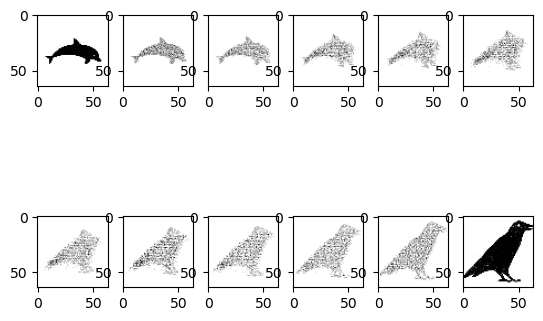

In [19]:
ga.plot()

## Model with unlimited children (64x64 image) 180 sec (it's the same as 4096 and 1024)

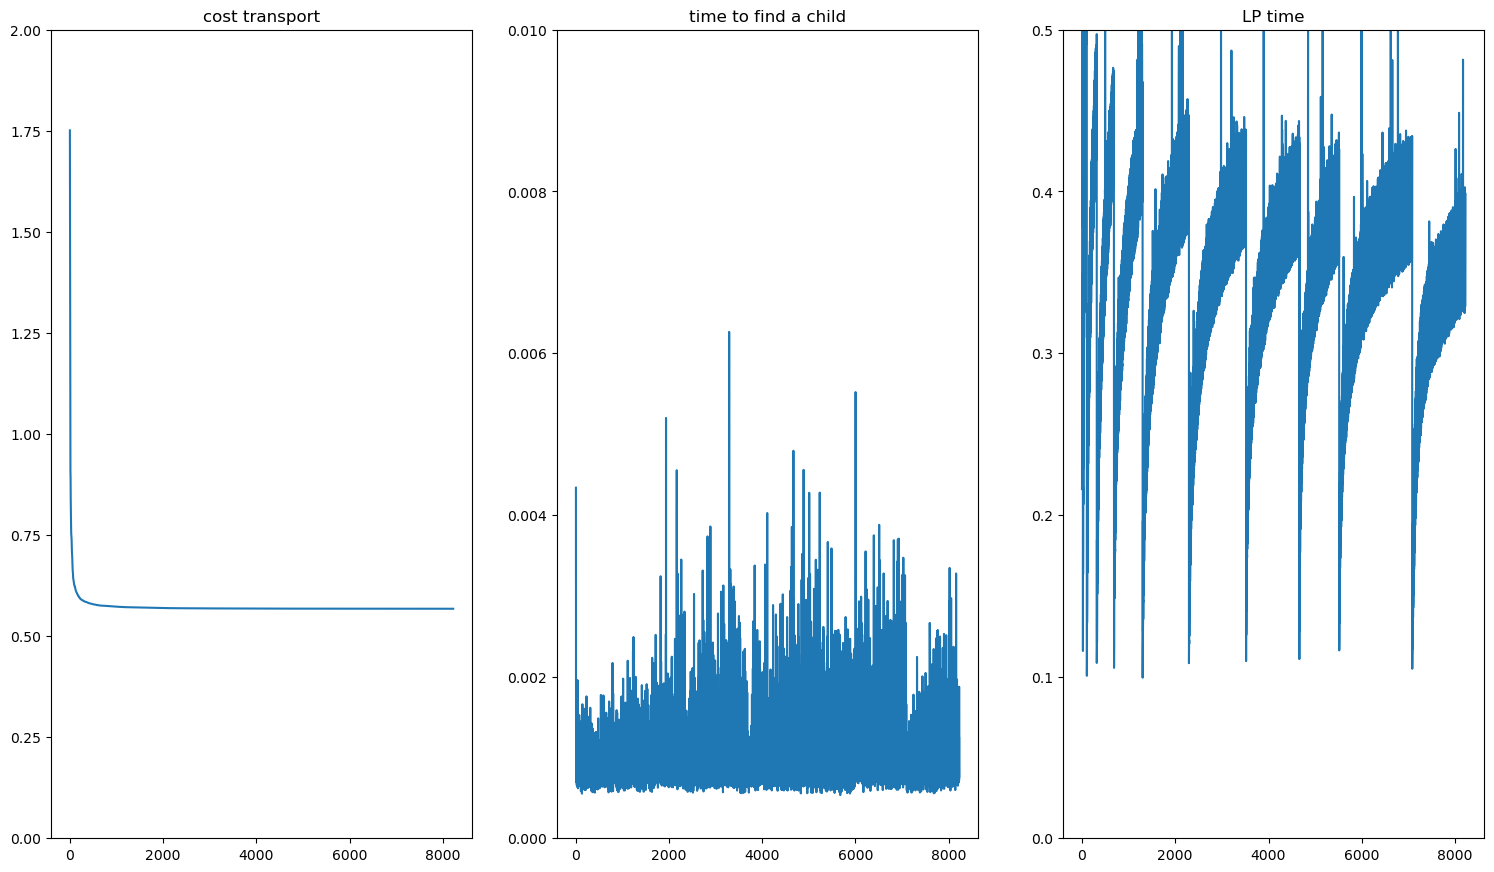

the final cost is 0.5678007499622706


In [76]:
figure, axis = plt.subplots(1, 3)

axis[0].plot(ga.cost)
axis[0].set_title("cost transport")
axis[0].set_ylim((0, 2))

axis[1].plot(ga.time_child)
axis[1].set_title("time to find a child")
axis[1].set_ylim((0, 0.01))
  
axis[2].plot(ga.time_model)
axis[2].set_title("LP time")
axis[2].set_ylim((0, 0.5))

figure.set_size_inches(18.5, 10.5)

plt.show()

print(f"the final cost is {ga.cost[-1]}")

## Model with 2 children (64x64) 180 sec 

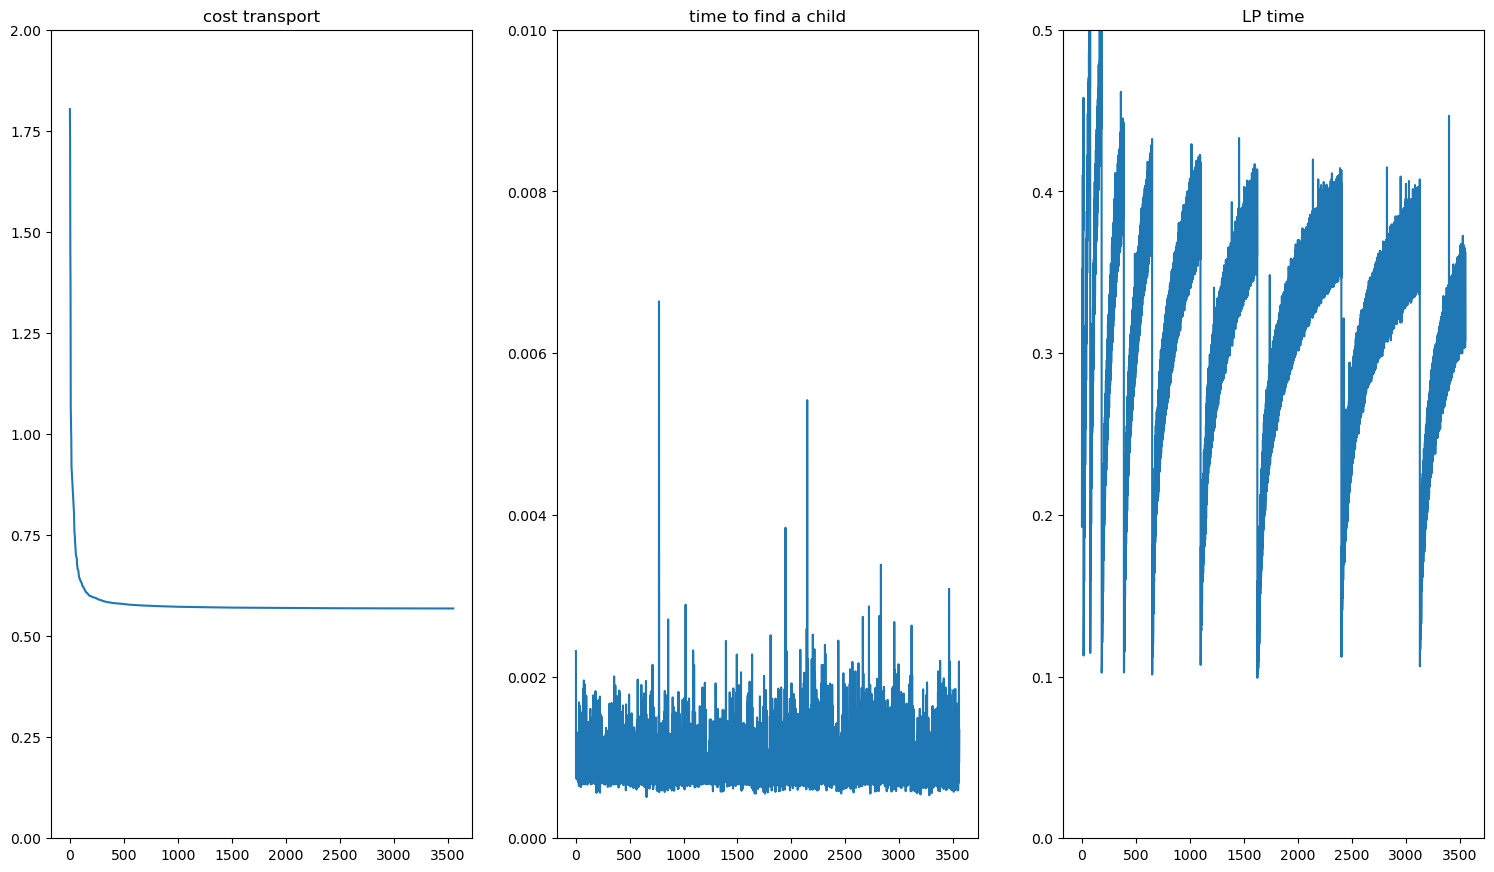

the final cost is 0.5684342761322148


In [60]:
figure, axis = plt.subplots(1, 3)
  
axis[0].plot(ga.cost)
axis[0].set_title("cost transport")
axis[0].set_ylim((0, 2))

axis[1].plot(ga.time_child)
axis[1].set_title("time to find a child")
axis[1].set_ylim((0, 0.01))
  
axis[2].plot(ga.time_model)
axis[2].set_title("LP time")
axis[2].set_ylim((0, 0.5))

figure.set_size_inches(18.5, 10.5)

plt.show()

print(f"the final cost is {ga.cost[-1]}")

## Model with 2 children (64x64) 180 sec (1 parent -> multi children)

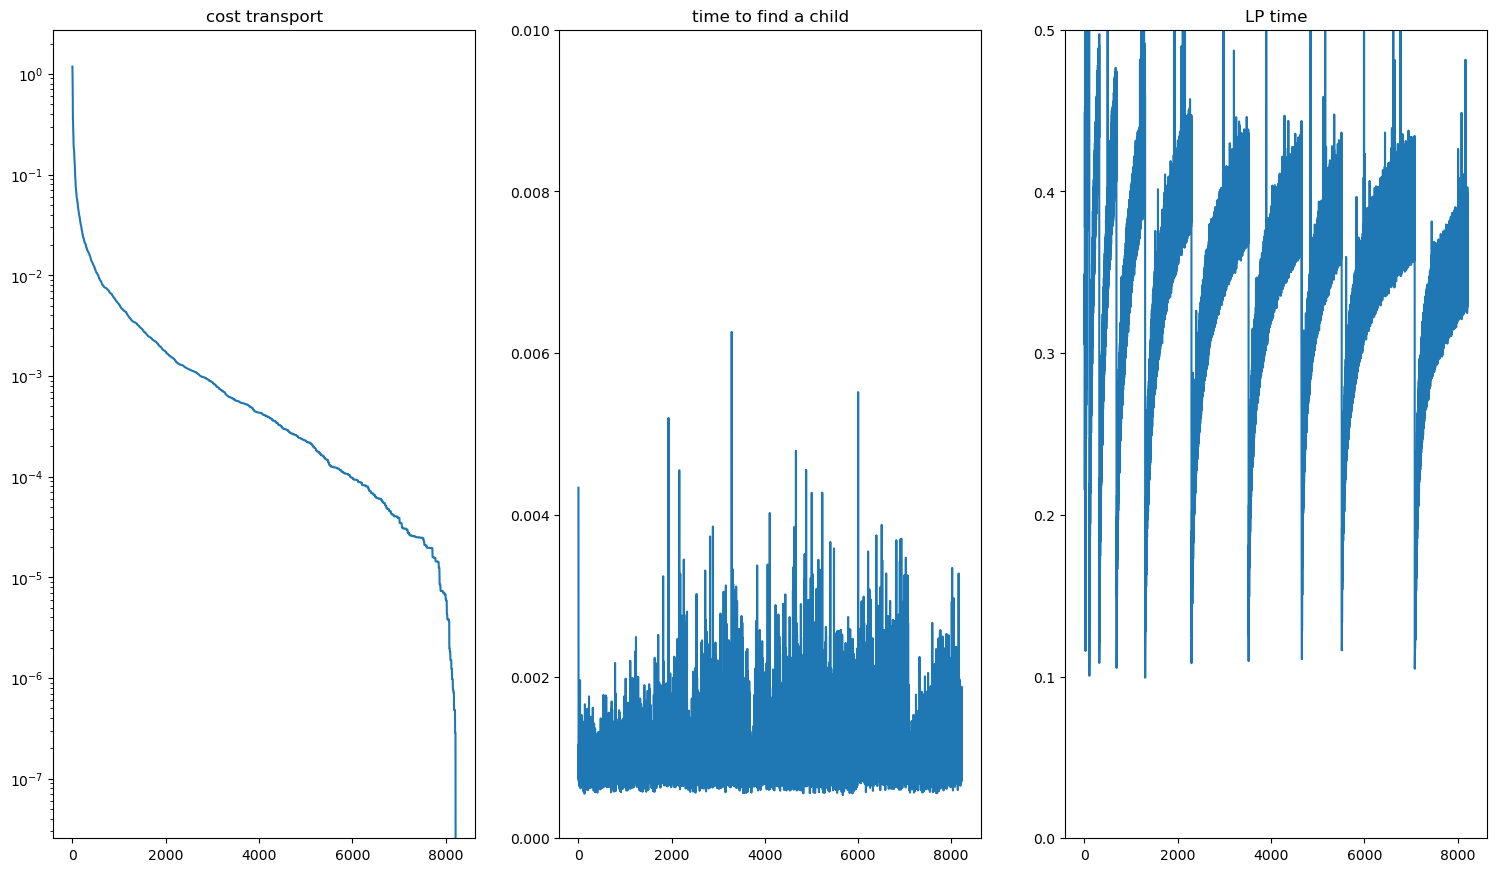

the final cost is 0.5678007499622706


In [77]:
figure, axis = plt.subplots(1, 3)
  
axis[0].plot(np.array(ga.cost)-0.5678007499622706)
axis[0].set_title("cost transport")
axis[0].set_yscale('log')

axis[1].plot(ga.time_child)
axis[1].set_title("time to find a child")
axis[1].set_ylim((0, 0.01))
  
axis[2].plot(ga.time_model)
axis[2].set_title("LP time")
axis[2].set_ylim((0, 0.5))

figure.set_size_inches(18.5, 10.5)

plt.show()

print(f"the final cost is {ga.cost[-1]}")

## 192x192 image barycenter plot

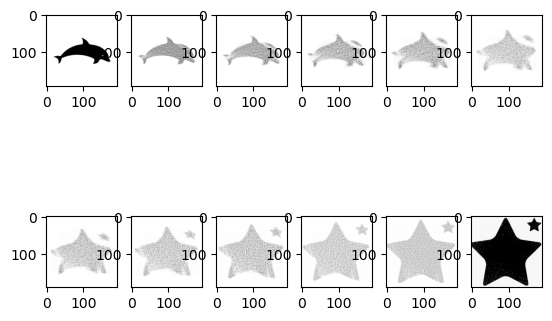

In [186]:
ga.reduce()
ga.plot()

## Model with unlimited children (192x192 image) 300 sec 

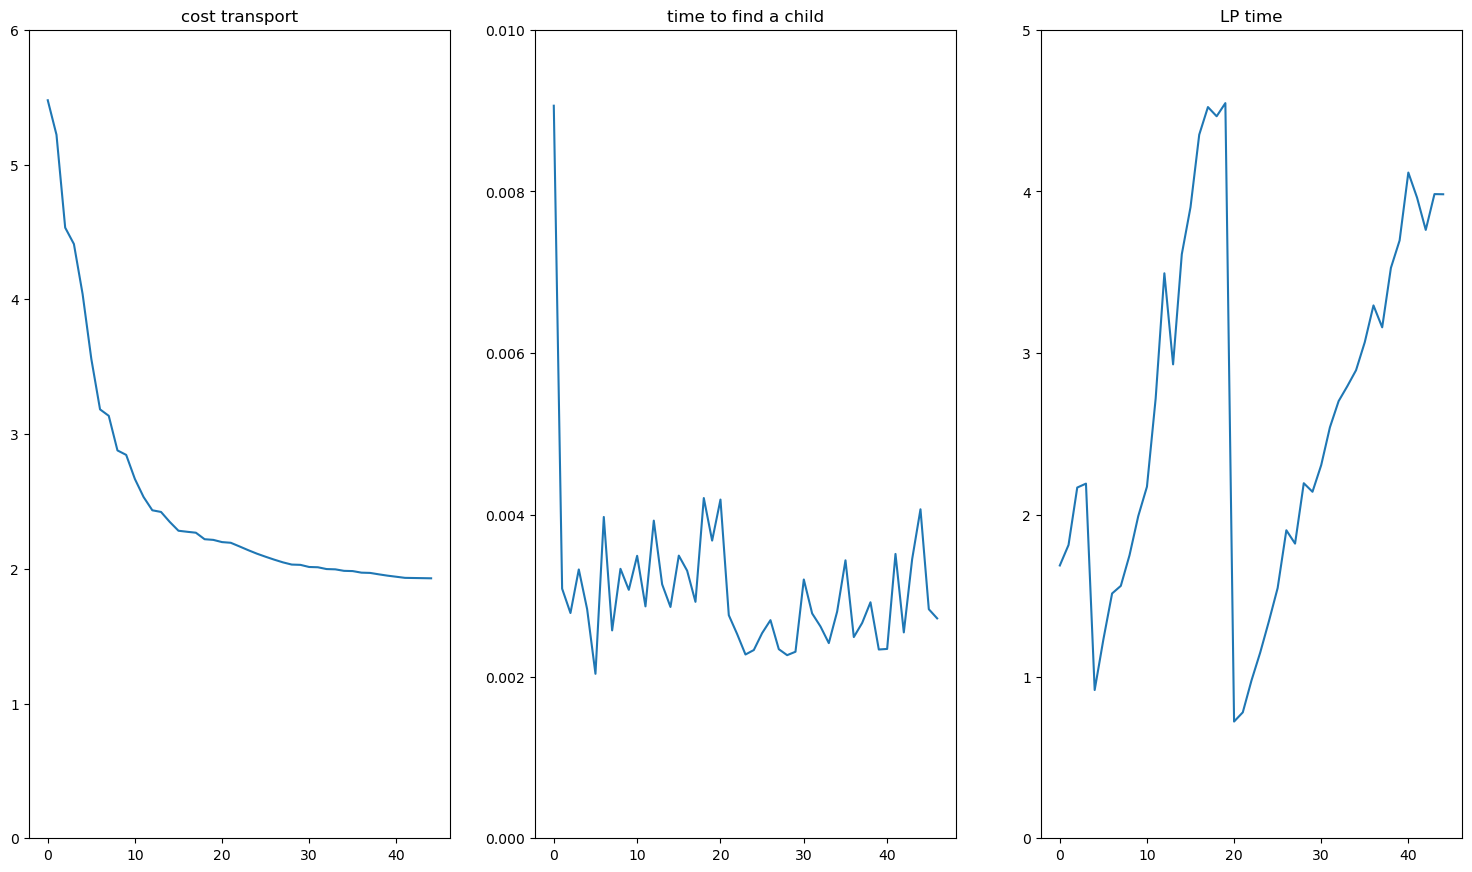

the final cost is 1.9293000693731583


In [84]:
figure, axis = plt.subplots(1, 3)
  
axis[0].plot(ga.cost)
axis[0].set_title("cost transport")
axis[0].set_ylim((0, 6))

axis[1].plot(ga.time_child)
axis[1].set_title("time to find a child")
axis[1].set_ylim((0, 0.01))
  
axis[2].plot(ga.time_model)
axis[2].set_title("LP time")
axis[2].set_ylim((0, 5))

figure.set_size_inches(18.5, 10.5)

plt.show()

print(f"the final cost is {ga.cost[-1]}")

## Model with 1024 children (192x192 image) 300 sec 

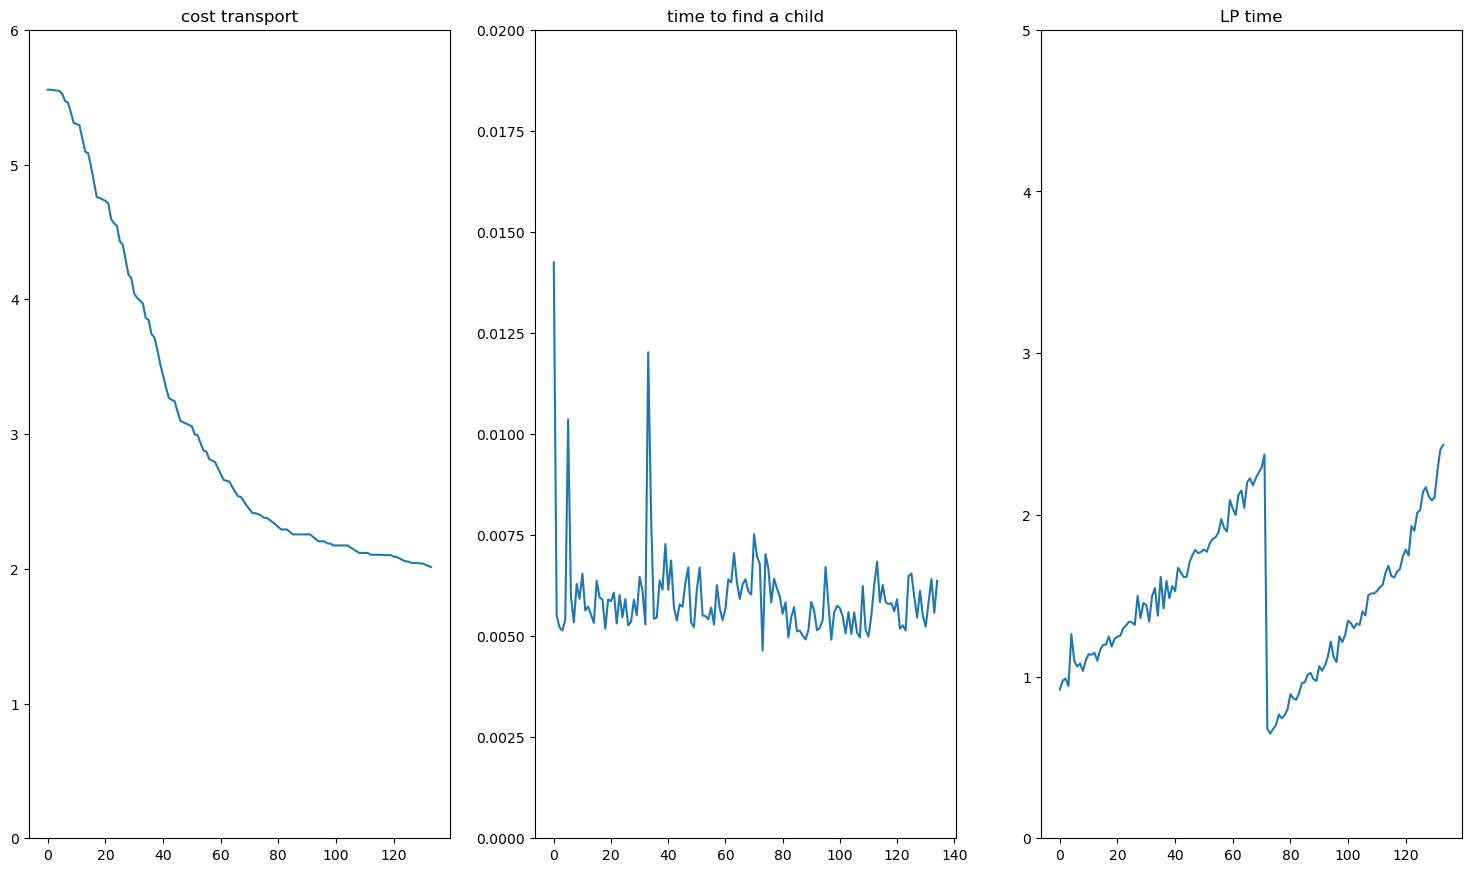

the final cost is 2.012642734967695


In [89]:
figure, axis = plt.subplots(1, 3)
  
axis[0].plot(ga.cost)
axis[0].set_title("cost transport")
axis[0].set_ylim((0, 6))

axis[1].plot(ga.time_child)
axis[1].set_title("time to find a child")
axis[1].set_ylim((0, 0.02))
  
axis[2].plot(ga.time_model)
axis[2].set_title("LP time")
axis[2].set_ylim((0, 5))

figure.set_size_inches(18.5, 10.5)

plt.show()

print(f"the final cost is {ga.cost[-1]}")

## Model with 4096 children (192x192 image) 300 sec 

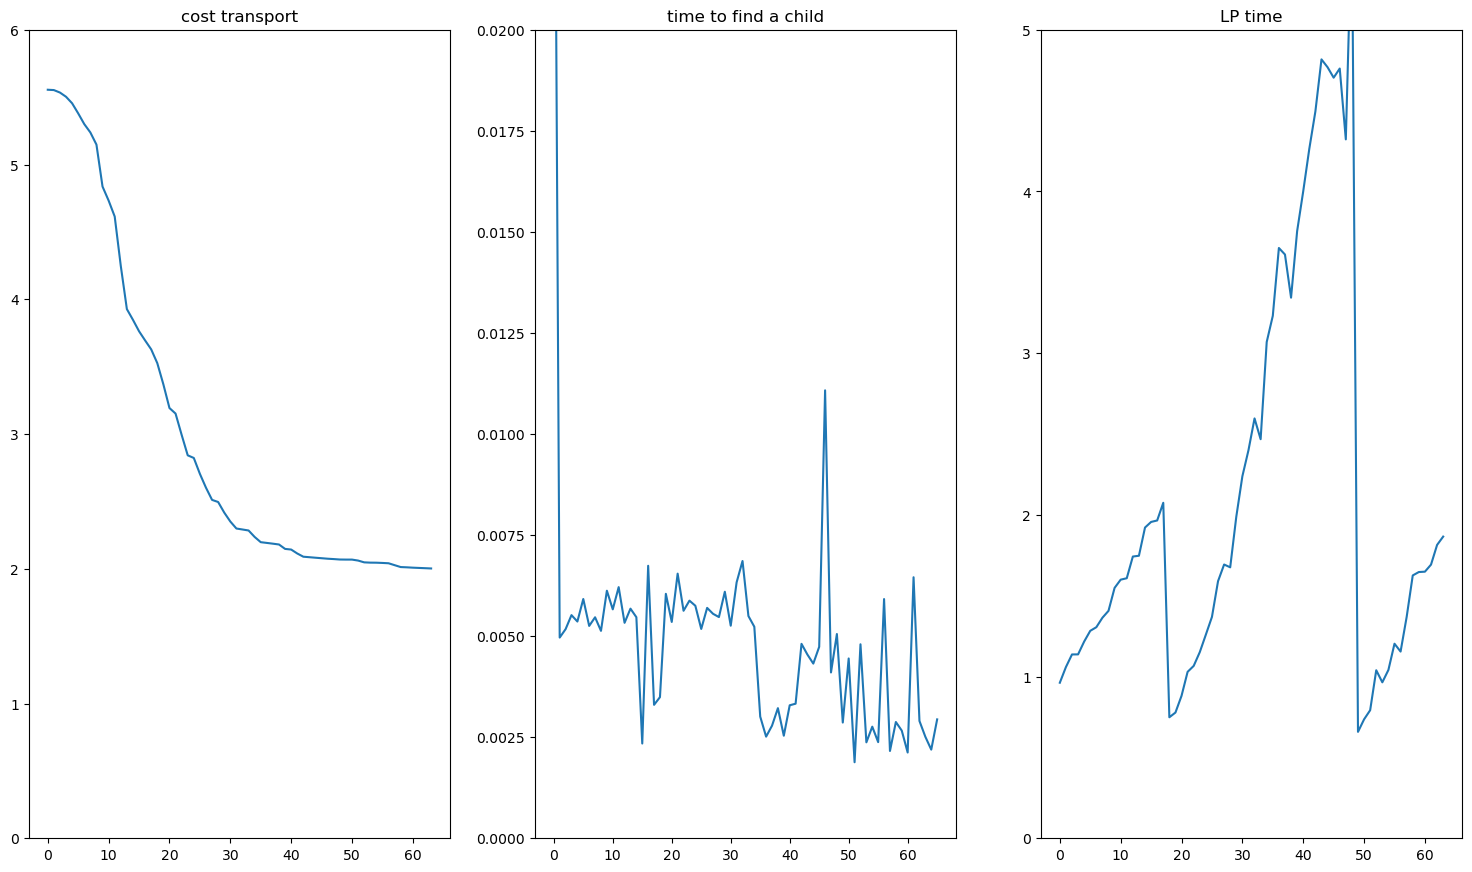

the final cost is 2.0023058250807053


In [93]:
figure, axis = plt.subplots(1, 3)
  
axis[0].plot(ga.cost)
axis[0].set_title("cost transport")
axis[0].set_ylim((0, 6))

axis[1].plot(ga.time_child)
axis[1].set_title("time to find a child")
axis[1].set_ylim((0, 0.02))
  
axis[2].plot(ga.time_model)
axis[2].set_title("LP time")
axis[2].set_ylim((0, 5))

figure.set_size_inches(18.5, 10.5)

plt.show()

print(f"the final cost is {ga.cost[-1]}")

## Model with 2 children (192x192 image) 300 sec

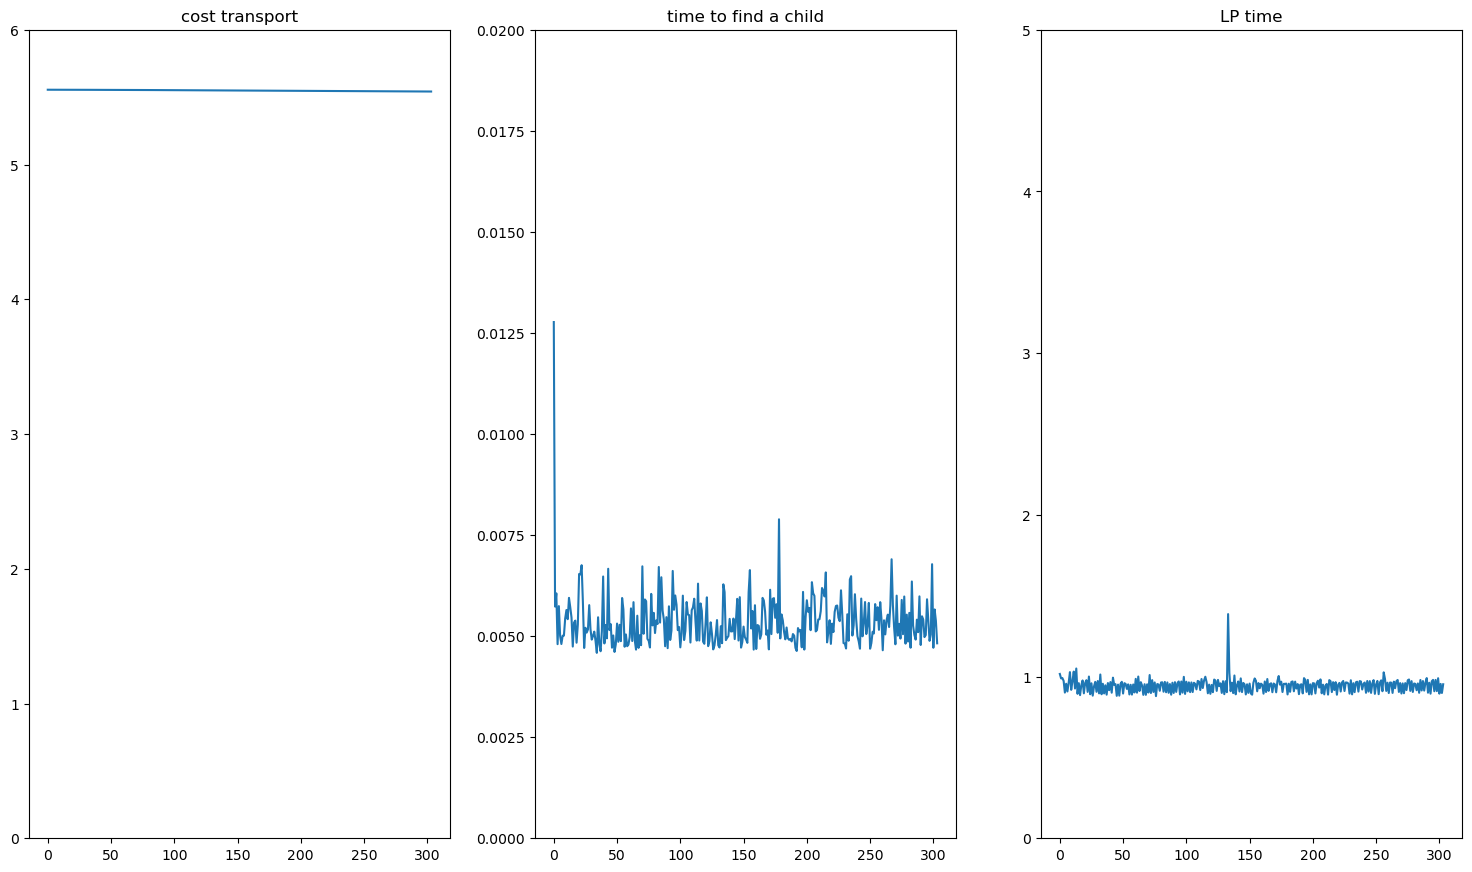

the final cost is 5.541757056412402


In [97]:
figure, axis = plt.subplots(1, 3)
  
axis[0].plot(ga.cost)
axis[0].set_title("cost transport")
axis[0].set_ylim((0, 6))

axis[1].plot(ga.time_child)
axis[1].set_title("time to find a child")
axis[1].set_ylim((0, 0.02))
  
axis[2].plot(ga.time_model)
axis[2].set_title("LP time")
axis[2].set_ylim((0, 5))

figure.set_size_inches(18.5, 10.5)

plt.show()

print(f"the final cost is {ga.cost[-1]}")

## Model with 2 children (192x192 image) 300 sec (1 parent -> multi children)

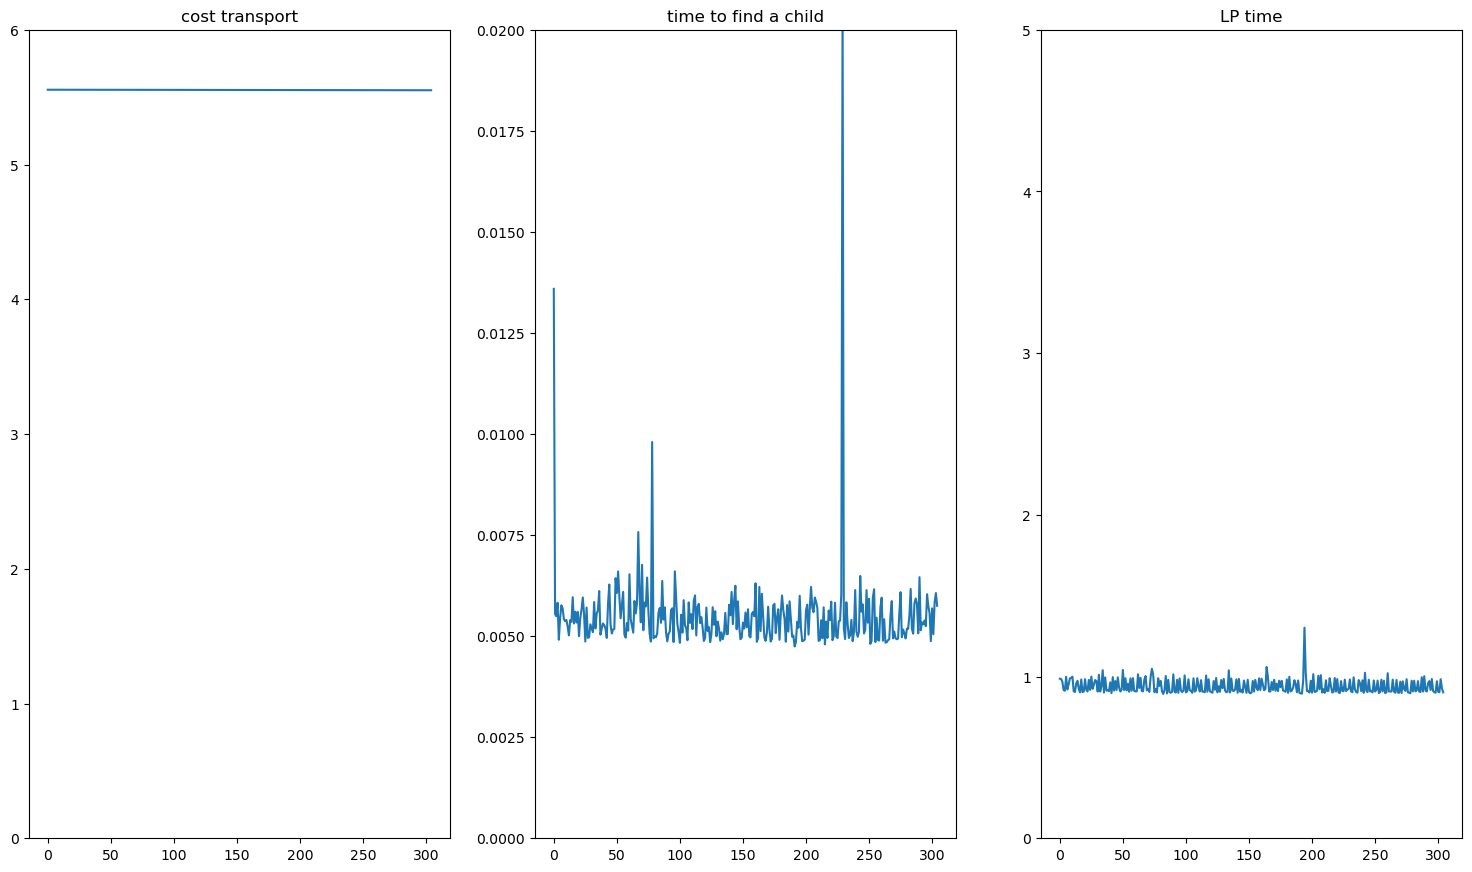

the final cost is 5.551177563831876


In [160]:
figure, axis = plt.subplots(1, 3)

axis[0].plot(ga.cost)
axis[0].set_title("cost transport")
axis[0].set_ylim((0, 6))

axis[1].plot(ga.time_child)
axis[1].set_title("time to find a child")
axis[1].set_ylim((0, 0.02))
  
axis[2].plot(ga.time_model)
axis[2].set_title("LP time")
axis[2].set_ylim((0, 5))

figure.set_size_inches(18.5, 10.5)

plt.show()

print(f"the final cost is {ga.cost[-1]}")